# Import Statements, Preliminaries

In [5]:
%autosave 180

Autosaving every 180 seconds


In [2]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal
from multiprocessing import Pool
from matplotlib import pyplot as plt
from astropy.utils.data import get_pkg_data_filename
import galsim
import os
import math
import time
import logging
import sys
#from astropy.io import fits
import fitsio

In [3]:
simname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/mag2/Chinchilla-4-y3wlpz.0.fits"
truthname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/Chinchilla-4_lensed.4.fits"

In [4]:
#simhdu = fits.open(simname)
#truthhdu = fits.open(truthname)
#sim_table = simhdu[1].data
#truth_table = truthhdu[1].data

#cat = galsim.Catalog(cat_file_name)

#noisy_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisy.fits')
#noisefree_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisefree.fits')

# Functions and List Creation

In [29]:
file= os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')

span = range(10000)


_RA = fitsio.read(file, columns='RA', rows=span, ext=1)
_DEC = fitsio.read(file, columns='DEC', rows=span, ext=1)
_HLR = fitsio.read(file, columns='SIZE', rows=span, ext=1)
LMAG = fitsio.read(file, columns = 'LMAG', rows=span, ext=1)
EPSILON = fitsio.read(file, columns='EPSILON', rows=span, ext=1)
RBAND = lmag[:,1]
E1 = epsilon[:,0]
E2 = epsilon[:,1]
#rband = truth_table['LMAG'][:,1] #grizy
#_ra = truth_table['RA']
#_dec = truth_table['DEC']
#_hlr = truth_table['SIZE']
#te1 = truth_table['EPSILON'][:,0]
#te2 = truth_table['EPSILON'][:,1]

In [61]:
x, y = np.mgrid[-24.5:25.5:1, -24.5:25.5:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

def HSMfunc(integer):
    _nmoments, _gfluxes, _images, failures = ([] for i in range(4))
    for i in range(integer):
        rng = galsim.BaseDeviate(215324)
        gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005)
        # catalogs
        hlradius = _HLR[i]   
        elip1 = E1[i]
        elip2 = E2[i]
        mag = RBAND[i]
        gflux = 10**((mag-22.5)/(-2.5)) #gives flux in nanomaggies ??
        _gfluxes.append(gflux)
        #make galaxy
        gal = galsim.Gaussian(flux=gflux, half_light_radius=hlradius)
        # shearing
        gal = gal.shear(galsim.Shear(e1=elip1, e2=elip2))
        # create image, convolve
        image = galsim.ImageF(50, 50)
        final = galsim.Convolve([gal])
        image = final.drawImage(image, scale=0.2)
        image.addNoise(gaussiannoise)
        #create image...again
        image2 = galsim.ImageF(50, 50)
        final2 = galsim.Convolve([gal])
        image2 = final2.drawImage(image2, scale=0.2)
        _images.append(image2)
        #HSM
        nmoment = image.FindAdaptiveMom(strict = False ,guess_sig=hlradius*5)
        _nmoments.append(nmoment)
        if nmoment.moments_n_iter  == 0:
            failures.append(i)
    return _nmoments, _gfluxes, _images, failures 


def cheatfunc(integer):
    _covariances = []
    _noisematrices = []
    for i in range(integer):
        rng = galsim.BaseDeviate(215324)
        gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005)
        noiseimage = galsim.ImageF(50, 50)
        # catalogs
        hlradius = _HLR[i] 
        sigma = 1/(np.sqrt(2*np.log(2))) * hlradius    #is this right # Conversion from hlr to sigma necessary
        elip1 = E1[i]
        elip2 = E2[i]
        mag = RBAND[i]
        gflux = 10**((mag-22.5)/(-2.5))
        shearing2 = galsim.Shear(e1=-1*elip1, e2=elip2)
        matrix = (shearing2.getMatrix())*(sigma**2)*25 
        _covariances.append(matrix)
        noiseimage.addNoise(gaussiannoise)
        _noisematrices.append(noiseimage)
    return _covariances, _noisematrices

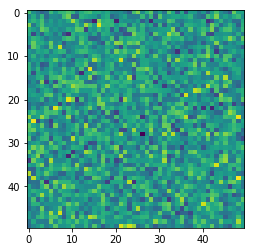

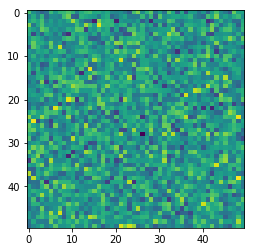

In [49]:
# image1 = galsim.ImageF(50, 50)
# image2 = galsim.ImageF(50,50)
# rng = galsim.BaseDeviate(215324)
# gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005)
# image1.addNoise(gaussiannoise)
# rng = galsim.BaseDeviate(215324)
# gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005)
# image2.addNoise(gaussiannoise)
# plt.figure()
# plt.imshow(image1.array)
# plt.show()
# plt.figure()
# plt.imshow(image2.array)

# Function Calls 1

In [74]:
_nmoments1, _gfluxes1, _images1, failures1  = HSMfunc(2000)
_covariances1, _noisematrices1 = cheatfunc(2000)

nmoments = [i for j, i in enumerate(_nmoments1) if j not in failures1]
gfluxes = [i for j, i in enumerate(_gfluxes1) if j not in failures1]
covariances = [i for j, i in enumerate(_covariances1) if j not in failures1] # HSM doesn't always converge well, so the purpose of this is to remove galaxies for which HSM didn't converge.
images = [i for j, i in enumerate(_images1) if j not in failures1]
noisematrices = [i for j, i in enumerate(_noisematrices1) if j not in failures1]
HLR = [i for j, i in enumerate(_HLR) if j not in failures1]
matrixfluxes = np.zeros(len(nmoments))
hsmfluxes = np.zeros(len(nmoments))

for j in range(len(nmoments)):
    rv = multivariate_normal([0, 0], covariances[j])
    r1 = np.sum(np.multiply(rv.pdf(pos), images[j].array + noisematrices[j].array))#*(1/_hlr[j]**2))# noisematrices[j].array
    r2 = np.sum(np.multiply(rv.pdf(pos), rv.pdf(pos)))
    matrixfluxes[j] = r1/r2
    
for i in range(len(nmoments)):
    hsmfluxes[i] = nmoments[i].moments_amp

In [43]:
# from scipy import integrate
# rv = multivariate_normal([0, 0], covariances[j])
# f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3,figsize=(15,15))
# im1 = ax1.imshow(rv.pdf(pos)*gfluxes[0])
# im2 = ax2.imshow(images[0].array)
# im3 = ax3.imshow(images[0].array-rv.pdf(pos)*gfluxes[0])
# f.colorbar(im1,ax=ax1)
# f.colorbar(im2,ax=ax2)
# f.colorbar(im3,ax=ax3)

# grid = np.array([[integrate.dblquad(lambda b, a : rv.pdf([a,b]), x, x+1, lambda a: y, lambda a: y+1)[0] for y in range(-25, 25)] for x in range(-25, 25)])

# print(grid.shape)
# im4 = ax4.imshow(grid*gfluxes[0])
# im5 = ax5.imshow(images[0].array)
# im6 = ax6.imshow(images[0].array-grid*gfluxes[0])
# f.colorbar(im4,ax=ax4)
# f.colorbar(im5,ax=ax5)
# f.colorbar(im6,ax=ax6)

# im7 = ax7.imshow(rv.pdf(pos)*gfluxes[0])
# im8 = ax8.imshow(grid*gfluxes[0])
# im9 = ax9.imshow(rv.pdf(pos)*gfluxes[0]-grid*gfluxes[0])
# f.colorbar(im7,ax=ax7)
# f.colorbar(im8,ax=ax8)
# f.colorbar(im9,ax=ax9)

# f.tight_layout()
# print(np.sum(images[0].array), gfluxes[0])

# Plot of Matrix Flux vs. HSM Flux and Plot of Matrix Flux vs. Galaxy Flux

intercept: -0.005120356153456074
slope: [1.04481908]


Text(0, 0.5, 'hsm fluxes')

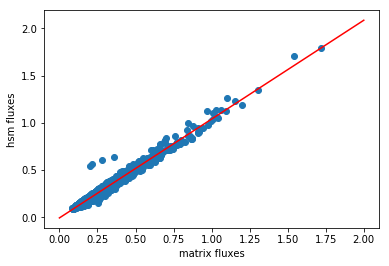

In [75]:
from sklearn.linear_model import LinearRegression
matrixfluxes1 = matrixfluxes.reshape((-1, 1))
model = LinearRegression().fit(matrixfluxes1, hsmfluxes)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
plt.figure()
z = np.linspace(0, 2, 100)
y = z*model.coef_ + model.intercept_

plt.plot(z, y, '-r')
plt.scatter(matrixfluxes, hsmfluxes)
plt.xlabel("matrix fluxes")
plt.ylabel("hsm fluxes")



Text(0, 0.5, 'galaxy fluxes')

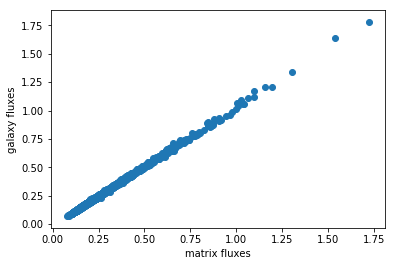

In [76]:
plt.figure()
plt.scatter(matrixfluxes, gfluxes)
plt.xlabel("matrix fluxes")
plt.ylabel("galaxy fluxes")

Text(0, 0.5, 'hsm fluxes')

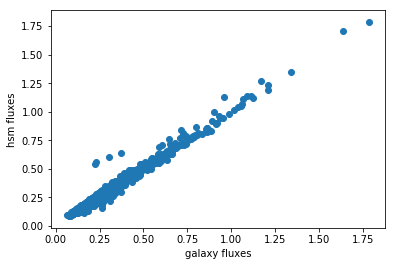

In [77]:
plt.scatter(gfluxes, hsmfluxes)
plt.xlabel("galaxy fluxes")
plt.ylabel("hsm fluxes")

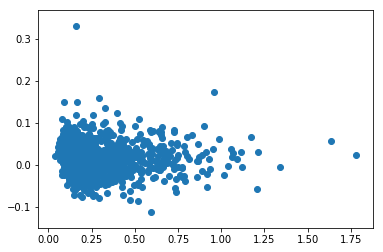

In [28]:
plt.scatter(gfluxes, hsmfluxes - gfluxes)

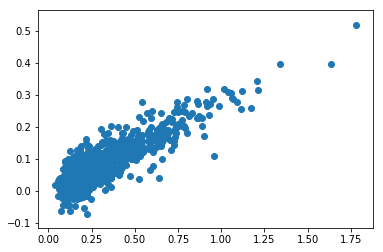

In [29]:
plt.scatter(gfluxes, [matrixfluxes[i]-gfluxes[i] for i in range(len(matrixfluxes))])

# Delta Flux Function Calls

In [78]:
_nmoments1, _gfluxes1, _images1, failures  = HSMfunc(2000)
_covariances1, _noisematrices1 = cheatfunc(2000)

nmoments = [i for j, i in enumerate(_nmoments1) if j not in failures]
gfluxes = [i for j, i in enumerate(_gfluxes1) if j not in failures]
covariances = [i for j, i in enumerate(_covariances1) if j not in failures]
images = [i for j, i in enumerate(_images1) if j not in failures]
noisematrices = [i for j, i in enumerate(_noisematrices1) if j not in failures]

dmatrixfluxes = np.zeros(len(nmoments))
dhsmfluxes = np.zeros(len(nmoments))

for j in range(len(nmoments)):
    rv = multivariate_normal([0, 0], covariances[j])
    r1 = np.sum(np.multiply(rv.pdf(pos), noisematrices[j].array)) # * (1/_hlr[j]**2)) noisematrices[j].array
    r2 = np.sum(np.multiply(rv.pdf(pos), rv.pdf(pos))) #/(_hlr[j])**2)
    dmatrixfluxes[j] = r1/r2
    
for i in range(len(nmoments)):
    dhsmfluxes[i] = nmoments[i].moments_amp - gfluxes[i]

In [53]:
print(np.amax(hsmfluxes), np.amin(np.abs(hsmfluxes)), np.sum(hsmfluxes)/len(hsmfluxes))

print(np.amax(matrixfluxes), np.amin(np.abs(matrixfluxes)), np.sum(matrixfluxes)/len(matrixfluxes))

0.33051067396919787 2.7610082536377867e-06 0.009847692735859243
0.023758407472713697 4.359348863364848e-06 0.013476821995858392


In [54]:
# plt.figure()
# plt.scatter(matrixfluxes, gfluxes)
# plt.xlabel("matrix fluxes")
# plt.ylabel("galaxy fluxes")

Text(0, 0.5, 'hsm fluxes')

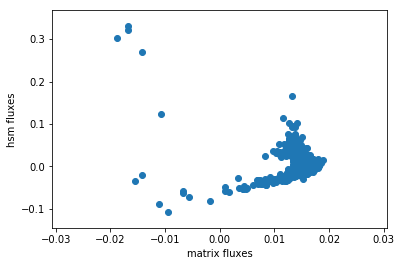

In [79]:
plt.figure()
plt.scatter(dmatrixfluxes, dhsmfluxes)
#plt.ylim([-0.03, 0.03])
#plt.xlim([-0.03, 0.03])
plt.xlabel("matrix fluxes")
plt.ylabel("hsm fluxes")

In [56]:
# plt.figure()
# plt.scatter(hsmfluxes, gfluxes)
# plt.xlabel("hsm fluxes")
# plt.ylabel("galaxy fluxes")